In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("compressed_banding_videos.csv")
df2 = pd.read_csv("compressed_banding_videos.csv", index_col=2)

In [ ]:
cambiScores = df.iloc[:,9]
vmafScores = df.iloc[:,10]
SIScores = df.iloc[:,14]
TIScores = df.iloc[:,15]

In [ ]:
vidRefNames = df.loc[:,"Ref"]
uniqueRefNames = pd.unique(vidRefNames)
# train contains list of video names reserved for the test dataset, and vice versa
train, test = train_test_split(uniqueRefNames,test_size=0.1,shuffle=True,random_state=0)
trainDF = df2.drop(test,axis=0)
#trainDF.to_csv("trainVideoSet.csv")
testDF = df2.drop(train,axis=0)
#testDF.to_csv("testVideoSet.csv")

In [ ]:
print("No. of reference videos in train set: ",train.size)
print("No. of reference videos in Test set: ",test.size)

In [ ]:
cambiScoresTrain = trainDF.loc[:,'CAMBI']
vmafScoresTrain = trainDF.loc[:,'VMAF']
SIScoresTrain = trainDF.loc[:,'SI']
TIScoresTrain = trainDF.loc[:,'TI']

In [ ]:
cambiScoresTest = testDF.loc[:,'CAMBI']
vmafScoresTest = testDF.loc[:,'VMAF']
SIScoresTest = testDF.loc[:,'SI']
TIScoresTest = testDF.loc[:,'TI']

In [ ]:
fig2 = plt.figure(constrained_layout=True)
Gridspec = gridspec.GridSpec(nrows=2,ncols=2,figure=fig2)

subfigure_1 = fig2.add_subfigure(Gridspec[0,0])
subplots_1 = subfigure_1.subplots(1,1)
subplots_1.hist(cambiScores)
subplots_1.hist(cambiScoresTrain)
subplots_1.set_xlabel("CAMBI"); subplots_1.set_ylabel("Count")
subplots_1.legend(["Dataset","Train"])
subplots_1.set_title("Distribution of CAMBI Scores")

subfigure_2 = fig2.add_subfigure(Gridspec[0,1])
subplots_2 = subfigure_2.subplots(1,1)
subplots_2.hist(vmafScores)
subplots_2.hist(vmafScoresTrain)
subplots_2.set_xlabel("VMAF"); subplots_2.set_ylabel("Count")
subplots_2.legend(["Dataset","Train"])
subplots_2.set_title("Distribution of VMAF Scores")

subfigure_3 = fig2.add_subfigure(Gridspec[1,0])
subplots_3 = subfigure_3.subplots(1,1)
subplots_3.hist(SIScores)
subplots_3.hist(SIScoresTrain)
subplots_3.set_xlabel("SI"); subplots_3.set_ylabel("Count")
subplots_3.legend(["Dataset","Train"])
subplots_3.set_title("Distribution of SI Scores")

subfigure_4 = fig2.add_subfigure(Gridspec[1,1])
subplots_4 = subfigure_4.subplots(1,1)
subplots_4.hist(TIScores)
subplots_4.hist(TIScoresTrain)
subplots_4.set_xlabel("TI"); subplots_4.set_ylabel("Count")
subplots_4.legend(["Dataset","Train"])
subplots_4.set_title("Distribution of TI Scores")

fig2.suptitle("trainVideoSet Distribution")

plt.show()

In [ ]:
testDF = pd.read_csv("testVideoSet.csv")
cambiScoresTest = testDF.loc[:,'CAMBI']
bbandScoresTest = testDF.loc[:,'BBAND']
filteredbbandScoresTest = testDF.loc[:,'BBAND(Adaband)']
plt.hist(cambiScoresTest)
plt.title("Distribution of CAMBI Scores in Test Set")
plt.xlabel("CAMBI"); plt.ylabel("Count")
plt.show()

In [ ]:
plt.hist(bbandScoresTest)
plt.hist(filteredbbandScoresTest)
plt.title("Distribution of BBAND Scores in Test Set")
plt.legend(["BBAND","BBAND(Adaband)"])
plt.xlabel("BBAND"); plt.ylabel("Count")
plt.show()

In [ ]:
plt.scatter(cambiScoresTest,bbandScoresTest)
plt.title("CAMBI vs BBAND in Test Set")
plt.xlabel("CAMBI"); plt.ylabel("BBAND")
plt.show()

In [ ]:
# Scatter plot of BBABD vs BBAND(Adaband) in test set
plt.scatter(bbandScoresTest,filteredbbandScoresTest)
plt.title("BBAND vs BBAND(Adaband) in Test Set")
plt.xlabel("BBAND"); plt.ylabel("BBAND(Adaband)")
plt.show()
# This shows the effect of the filtering on the BBAND scores

In [4]:
from library import hrNet
from src.auxFunctions import readFrames
from library import returnMetric, upSample2XTile

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 

alphas = [1.0, 0.01, 0.001, 0.0001, 1e-05, 5e-06, 2.5e-06, 1.5e-06 ,1e-06]
generator = hrNet(2, [32, 64, 128, 256], 5).model()


patch_tmin1, patch_t, patch_tplus1 = readFrames("dataset/KristenAndSara_10frames_512x256.yuv420p",[512,256],1,7)
patch_tSmall = patch_t[:192,:192,:]
plt.imshow(patch_tSmall/255.0)
plt.axis('off')
plt.title("Input Patch")
plt.show() 

inputPatches = np.concatenate((patch_tSmall,patch_tSmall,patch_tSmall),axis=-1)
inputPatches = np.expand_dims(inputPatches,axis=0)/255.0

for _alpha in alphas:
    df = pd.read_json(f"results/HRNET_CAMBI_ALPHA{_alpha}.json")
    generator.load_weights(f'results/HRNET_CAMBI_ALPHA{_alpha}.h5')
    _output = generator(inputPatches, training=False)
    _outputUs = upSample2XTile(_output)
    patch_tSmallUS = upSample2XTile(np.expand_dims(patch_tSmall,0)/255.0)
    print(_alpha)
    print(returnMetric(_outputUs, patch_tSmallUS, height=192*2, width=192*2))
    plt.imshow(np.clip(_output[0],0,1))
    plt.axis('off')
    plt.title("Output Patch, alpha = " +str(_alpha))
    plt.show()

    plt.imshow(np.abs(_output[0] - (patch_tSmall/255.0))*10.0)
    plt.title("Patch Difference, alpha = " +str(_alpha))
    plt.axis('off')
    plt.show()
    print(df.loc[[1]])

generator.load_weights('results/HRNET_MSE.h5')
_output = generator(inputPatches, training=False)
_outputUs = upSample2XTile(_output)
patch_tSmallUS = upSample2XTile(np.expand_dims(patch_tSmall,0)/255.0)
print('MSE')
print(returnMetric(_outputUs, patch_tSmallUS, height=192*2, width=192*2))
plt.imshow(np.clip(_output[0],0,1))
plt.title("Output Patch, Model Trained w/ MSE Loss")
plt.axis('off')
plt.show()

plt.imshow(np.abs(_output[0] - (patch_tSmall/255.0))*10.0)
plt.title("Patch Difference, Model Trained w/ MSE Loss")
plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'library'

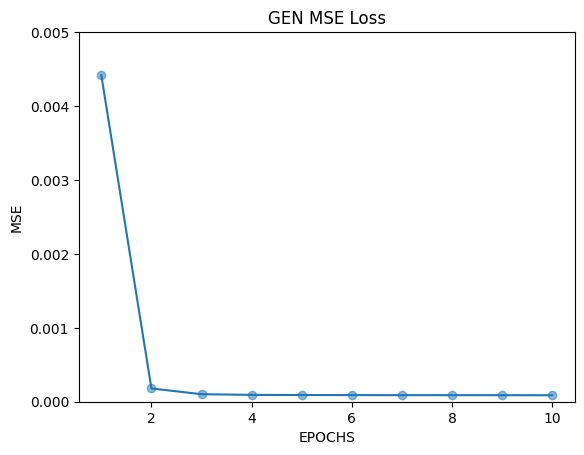

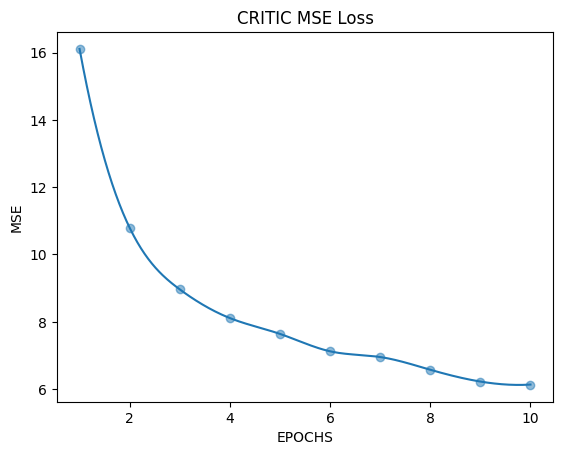

In [18]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from scipy.interpolate import make_interp_spline
from scipy.signal import medfilt
df= pd.read_json("results/HRNET_MSE.json")


# X_Y_Spline = make_interp_spline(range(1,11), df['MSELoss'],k=1)
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(1, 10, 500)
# Y_ = X_Y_Spline(X_)
losses = df['MSELoss'].tolist()
losses[5] = (losses[4] + losses[6])/2
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(range(1,11),losses, alpha=0.5)

plt.plot(list(range(1,11)),losses)
#plt.plot(X_, Y_)
plt.title("GEN MSE Loss")
plt.ylim(0,0.005)
plt.xlabel("EPOCHS"); plt.ylabel("MSE")
plt.show()

df= pd.read_json("results/CRITIC_MSE.json")

X_Y_Spline = make_interp_spline(range(1,11), df['MSELoss'],k=3)
Y_ = X_Y_Spline(X_)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(range(1,11),df['MSELoss'],alpha=0.5)
plt.plot(X_, Y_)
plt.title("CRITIC MSE Loss")
plt.xlabel("EPOCHS"); plt.ylabel("MSE")

plt.show()

In [3]:
import pandas as pd

DATAFRAME = pd.read_csv('dataFrames/trainVideoSet.csv')
vmaf_lim = 75
cambi_lim = 10
DATAFRAME = DATAFRAME[DATAFRAME['VMAF'] >= vmaf_lim]
DATAFRAME = DATAFRAME[DATAFRAME['CAMBI'] >= cambi_lim]
#DATAFRAME = DATAFRAME[DATAFRAME['NumFrames'] < 300]
DATAFRAME = DATAFRAME.reset_index(drop=True)
SAMPLE = DATAFRAME.sample(n=10, replace=False,random_state=10)
#SAMPLE = SAMPLE.drop(SAMPLE.index[[0,7,10,12]])
SAMPLE = SAMPLE.reset_index(drop=True)
SAMPLE.head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'dataFrames/trainVideoSet_perframeCambi.csv'

In [33]:
SAMPLE = SAMPLE.drop(SAMPLE.index[[7,10]])
SAMPLE = SAMPLE.reset_index(drop=True)
SAMPLE.head(10)

,Ref,Codec,CRF,Comp,FileStream,PSNR_Y,PSNR_CB,PSNR_CR,SSIM,CAMBI,VMAF,Height,Width,NumFrames,SI,TI
0,MINECRAFT_10.yuv,H264,21,MINECRAFT_10_H264_CRF21_.yuv,MINECRAFT_10_H264_CRF21_.txt,52.242163,59.712451,59.359443,0.998717,16.486837,97.214924,1080,1920,300,39.60,4.01
1,wipe_3840x2160_5994_10bit_420_4653-4783.yuv,H265,31,wipe_3840x2160_5994_10bit_420_4653-4783_H265_C...,wipe_3840x2160_5994_10bit_420_4653-4783_H265_C...,47.606710,49.193790,52.401143,0.996102,15.750043,82.160064,1080,1920,130,11.70,1.96
2,DOLBY_ATMOS_UNFOLD_2_FEEL_EVERY_DIMENSION_LOSS...,H264,31,DOLBY_ATMOS_UNFOLD_2_FEEL_EVERY_DIMENSION_LOSS...,DOLBY_ATMOS_UNFOLD_2_FEEL_EVERY_DIMENSION_LOSS...,42.752466,47.529598,48.244188,0.990630,11.731413,89.044781,1080,1920,120,40.10,14.50
3,Dolby_Atmos_Natures_Fury_1920x1080_ATMOS_71-th...,AV1,51,Dolby_Atmos_Natures_Fury_1920x1080_ATMOS_71-th...,Dolby_Atmos_Natures_Fury_1920x1080_ATMOS_71-th...,48.150232,49.936955,50.370161,0.996215,16.195408,91.066029,1080,1920,120,41.30,48.00
4,BBubblesPitcherS1BVITexture_1920x1088_120fps_1...,H265,31,BBubblesPitcherS1BVITexture_1920x1088_120fps_1...,BBubblesPitcherS1BVITexture_1920x1088_120fps_1...,43.206013,39.589670,46.995226,0.987163,14.384339,82.766882,1088,1920,64,14.10,4.72
5,wipe_3840x2160_5994_10bit_420_2530-2660.yuv,AV1,13,wipe_3840x2160_5994_10bit_420_2530-2660_AV1_CR...,wipe_3840x2160_5994_10bit_420_2530-2660_AV1_CR...,51.415759,55.840549,58.344871,0.998803,14.074480,94.226689,1080,1920,130,9.36,2.17
6,A007C037_171117_R2HN_3.yuv,H265,31,A007C037_171117_R2HN_3_H265_CRF31_.yuv,A007C037_171117_R2HN_3_H265_CRF31_.txt,39.838162,41.308881,42.324087,0.989682,10.841581,86.270433,1080,1920,120,46.80,15.70
7,BSparklerBVIHFR_1920x1088_120fps_10bit_420.yuv,AV1,51,BSparklerBVIHFR_1920x1088_120fps_10bit_420_AV1...,BSparklerBVIHFR_1920x1088_120fps_10bit_420_AV1...,36.641926,40.030696,42.168643,0.982439,10.678007,86.189517,1088,1920,64,66.60,50.40
8,A007C036_171117_R2HN_3.yuv,AV1,26,A007C036_171117_R2HN_3_AV1_CRF26_.yuv,A007C036_171117_R2HN_3_AV1_CRF26_.txt,44.540467,46.894678,45.263829,0.996088,13.427882,98.503220,1080,1920,120,50.20,17.20
9,A007C035_171117_R2HN_2.yuv,H264,31,A007C035_171117_R2HN_2_H264_CRF31_.yuv,A007C035_171117_R2HN_2_H264_CRF31_.txt,40.557080,42.736988,42.541148,0.992557,16.017836,90.333974,1080,1920,120,51.60,18.50


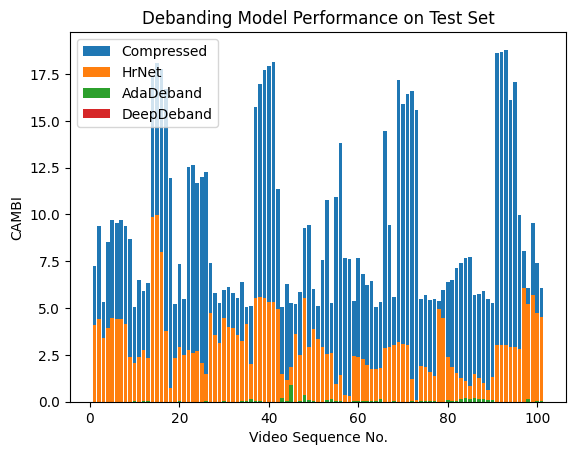

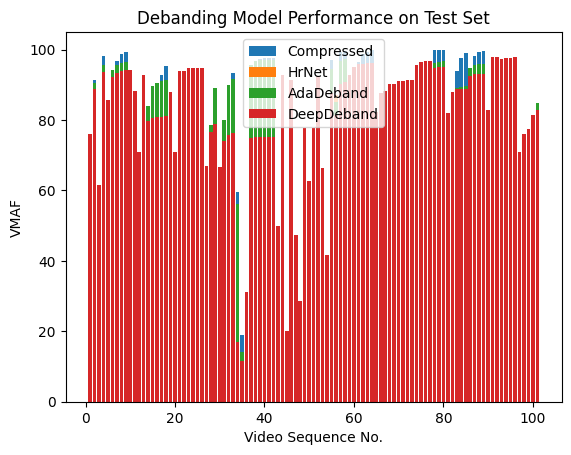

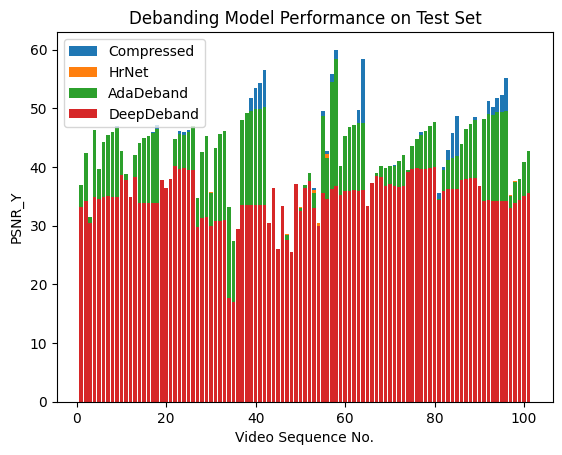

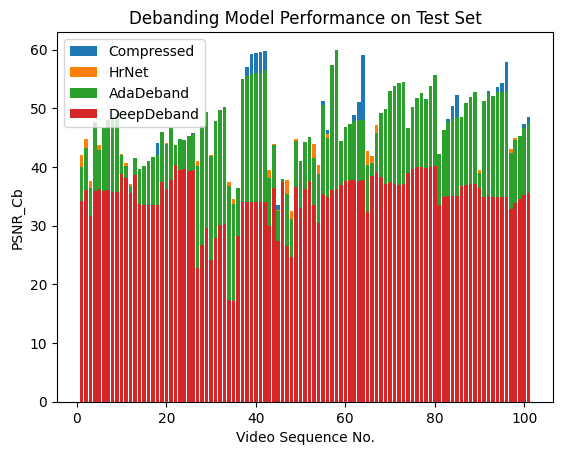

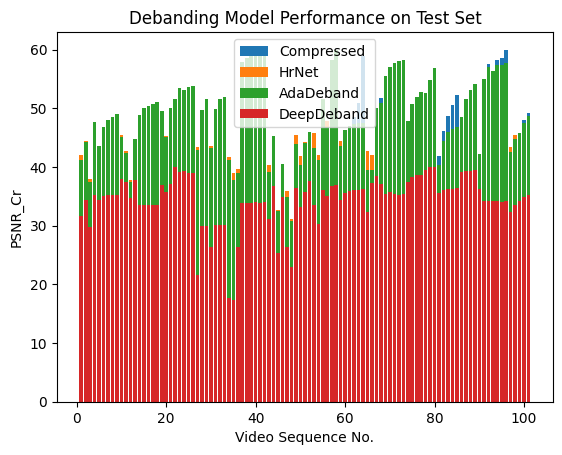

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dfComp = pd.read_csv("dataFrames/testVideoSet.csv")
dfDD = pd.read_csv("dataFrames/deepDebandFScores.csv")
dfAB = pd.read_csv("dataFrames/adabandImgScores.csv")
dfHR = pd.read_csv("dataFrames/hrNetImgScores.csv")

X = np.arange(1,102)


plt.bar(X,dfComp['CAMBI'])
plt.bar(X,dfHR['CAMBI'])
plt.bar(X,dfAB['CAMBI'])
plt.bar(X,dfDD['CAMBI'])
plt.title("Debanding Model Performance on Test Set")
plt.legend(["Compressed", "HrNet","AdaDeband", "DeepDeband"])
plt.xlabel("Video Sequence No."); plt.ylabel("CAMBI")
plt.show()

plt.bar(X,dfComp['VMAF'])
plt.bar(X,dfHR['VMAF'])
plt.bar(X,dfAB['VMAF'])
plt.bar(X,dfDD['VMAF'])
plt.legend(["Compressed", "HrNet","AdaDeband", "DeepDeband"])
plt.title("Debanding Model Performance on Test Set")
plt.xlabel("Video Sequence No."); plt.ylabel("VMAF")
plt.show()

plt.bar(X,dfComp['PSNR_Y'])
plt.bar(X,dfHR['PSNR_Y'])
plt.bar(X,dfAB['PSNR_Y'])
plt.bar(X,dfDD['PSNR_Y'])
plt.legend(["Compressed", "HrNet","AdaDeband", "DeepDeband"])
plt.title("Debanding Model Performance on Test Set")
plt.xlabel("Video Sequence No."); plt.ylabel("PSNR_Y")
plt.show()

plt.bar(X,dfComp['PSNR_CB'])
plt.bar(X,dfHR['PSNR_Cb'])
plt.bar(X,dfAB['PSNR_Cb'])
plt.bar(X,dfDD['PSNR_Cb'])
plt.legend(["Compressed", "HrNet","AdaDeband", "DeepDeband"])
plt.title("Debanding Model Performance on Test Set")
plt.xlabel("Video Sequence No."); plt.ylabel("PSNR_Cb")
plt.show()

plt.bar(X,dfComp['PSNR_CR'])
plt.bar(X,dfHR['PSNR_Cr'])
plt.bar(X,dfAB['PSNR_Cr'])
plt.bar(X,dfDD['PSNR_Cr'])
plt.legend(["Compressed", "HrNet","AdaDeband", "DeepDeband"])
plt.title("Debanding Model Performance on Test Set")
plt.xlabel("Video Sequence No."); plt.ylabel("PSNR_Cr")
plt.show()

In [19]:
print("Mean and STD CAMBI Scores for Compressed: ", dfComp['CAMBI'].mean(), "+-",  dfComp['CAMBI'].std())
print("Mean and STD CAMBI Scores for HrNet: ", dfHR['CAMBI'].mean(), "+-",  dfHR['CAMBI'].std())
print("Mean and STD CAMBI Scores for AdaBand: ", dfAB['CAMBI'].mean(), "+-",  dfAB['CAMBI'].std())
print("Mean and STD CAMBI Scores for DeepDeband: ", dfDD['CAMBI'].mean(), "+-",  dfDD['CAMBI'].std())



Mean and STD CAMBI Scores for Compressed:  9.258694405841586 +- 4.437130223899247
Mean and STD CAMBI Scores for HrNet:  3.0874627623762376 +- 1.7787449921970213
Mean and STD CAMBI Scores for AdaBand:  0.04615964356435643 +- 0.10099826517872315
Mean and STD CAMBI Scores for DeepDeband:  0.0 +- 0.0


In [20]:
print("Mean and STD VMAF Scores for Compressed: ", dfComp['VMAF'].mean(), "+-",  dfComp['VMAF'].std())
print("Mean and STD VMAF Scores for HrNet: ", dfHR['VMAF'].mean(), "+-",  dfHR['VMAF'].std())
print("Mean and STD VMAF Scores for AdaBand: ", dfAB['VMAF'].mean(), "+-",  dfAB['VMAF'].std())
print("Mean and STD VMAF Scores for DeepDeband: ", dfDD['VMAF'].mean(), "+-",  dfDD['VMAF'].std())

Mean and STD VMAF Scores for Compressed:  70.31129934033663 +- 28.676692810967324
Mean and STD VMAF Scores for HrNet:  71.3585599009901 +- 27.75280374293632
Mean and STD VMAF Scores for AdaBand:  72.20350776237623 +- 28.340389286049945
Mean and STD VMAF Scores for DeepDeband:  82.11029603960394 +- 18.009894244679874


In [21]:
print("Mean and STD PSNR_Y Scores for Compressed: ", dfComp['PSNR_Y'].mean(), "+-",  dfComp['PSNR_Y'].std())
print("Mean and STD PSNR_Y Scores for HrNet: ", dfHR['PSNR_Y'].mean(), "+-",  dfHR['PSNR_Y'].std())
print("Mean and STD PSNR_Y Scores for AdaBand: ", dfAB['PSNR_Y'].mean(), "+-",  dfAB['PSNR_Y'].std())
print("Mean and STD PSNR_Y Scores for DeepDeband: ", dfDD['PSNR_Y'].mean(), "+-",  dfDD['PSNR_Y'].std())

Mean and STD PSNR_Y Scores for Compressed:  40.99826984306931 +- 7.9881249201589695
Mean and STD PSNR_Y Scores for HrNet:  39.57968102970297 +- 5.315479173008046
Mean and STD PSNR_Y Scores for AdaBand:  41.53625625742575 +- 6.926798763641372
Mean and STD PSNR_Y Scores for DeepDeband:  34.8171717970297 +- 3.9450600346602434


In [25]:
print("Mean and STD PSNR_CB Scores for Compressed: ", dfComp['PSNR_CB'].mean(), "+-",  dfComp['PSNR_CB'].std())
print("Mean and STD PSNR_CB Scores for HrNet: ", dfHR['PSNR_Cb'].mean(), "+-",  dfHR['PSNR_Cb'].std())
print("Mean and STD PSNR_CB Scores for AdaBand: ", dfAB['PSNR_Cb'].mean(), "+-",  dfAB['PSNR_Cb'].std())
print("Mean and STD PSNR_CB Scores for DeepDeband: ", dfDD['PSNR_Cb'].mean(), "+-",  dfDD['PSNR_Cb'].std())

Mean and STD PSNR_CB Scores for Compressed:  45.90174284475248 +- 6.528852977803251
Mean and STD PSNR_CB Scores for HrNet:  44.412709356435634 +- 3.858564205178547
Mean and STD PSNR_CB Scores for AdaBand:  46.406186920792074 +- 6.028838492525232
Mean and STD PSNR_CB Scores for DeepDeband:  34.81616111386139 +- 4.39693769775141


In [26]:
print("Mean and STD PSNR_CR Scores for Compressed: ", dfComp['PSNR_CR'].mean(), "+-",  dfComp['PSNR_CR'].std())
print("Mean and STD PSNR_CR Scores for HrNet: ", dfHR['PSNR_Cr'].mean(), "+-",  dfHR['PSNR_Cr'].std())
print("Mean and STD PSNR_CR Scores for AdaBand: ", dfAB['PSNR_Cr'].mean(), "+-",  dfAB['PSNR_Cr'].std())
print("Mean and STD PSNR_CR Scores for DeepDeband: ", dfDD['PSNR_Cr'].mean(), "+-",  dfDD['PSNR_Cr'].std())

Mean and STD PSNR_CR Scores for Compressed:  47.90271866247525 +- 6.7511958190548835
Mean and STD PSNR_CR Scores for HrNet:  46.049147534653464 +- 3.792579529954083
Mean and STD PSNR_CR Scores for AdaBand:  48.5674269009901 +- 6.567025819494063
Mean and STD PSNR_CR Scores for DeepDeband:  34.44720419801981 +- 4.274763140256704
